In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
import random

In [2]:
!mkdir tusimple_preprocessed
!cd tusimple_preprocessed && mkdir training
!cd tusimple_preprocessed/training && mkdir frames && mkdir lane-masks

clips = '/kaggle/input/tusimple/TUSimple/train_set/clips/'
new_frames = '/kaggle/working/tusimple_preprocessed/training/frames'

# Copy the 20th frame from each clip
for i in os.listdir(clips):
    for j in os.listdir(os.path.join(clips, i)):
        frame = os.path.join(clips, i, j, '20.jpg')
        tmp = frame[:-7].split('/')[-2:]
        new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(new_frames, new_fn)
        shutil.copy(frame, new_file)
    print('Done with: ', i)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Done with:  0531
Done with:  0601
Done with:  0313-2
Done with:  0313-1


In [3]:
def generate_lane_mask(row, training_set=True):
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    for lane in lanes:    
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)

    path = '/kaggle/working/tusimple_preprocessed/training/lane-masks' if training_set else '/kaggle/working/tusimple_preprocessed/test/lane-masks'
    tmp = raw_file[:-7].split('/')[-2:]
    mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
    new_file = os.path.join(path, mask_fname)
    cv2.imwrite(new_file, mask)
    return mask_fname

In [4]:
df_0601 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json', lines=True)
df_0313 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0313.json', lines=True)
df_0531 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0531.json', lines=True)
df = pd.concat([df_0601, df_0313, df_0531])

for index, row in df.iterrows():
    generate_lane_mask(row)
    if index % 200 == 0:
        print('Row: ', index)

Row:  0
Row:  200
Row:  400
Row:  0
Row:  200
Row:  400
Row:  600
Row:  800
Row:  1000
Row:  1200
Row:  1400
Row:  1600
Row:  1800
Row:  2000
Row:  2200
Row:  2400
Row:  2600
Row:  2800
Row:  0
Row:  200


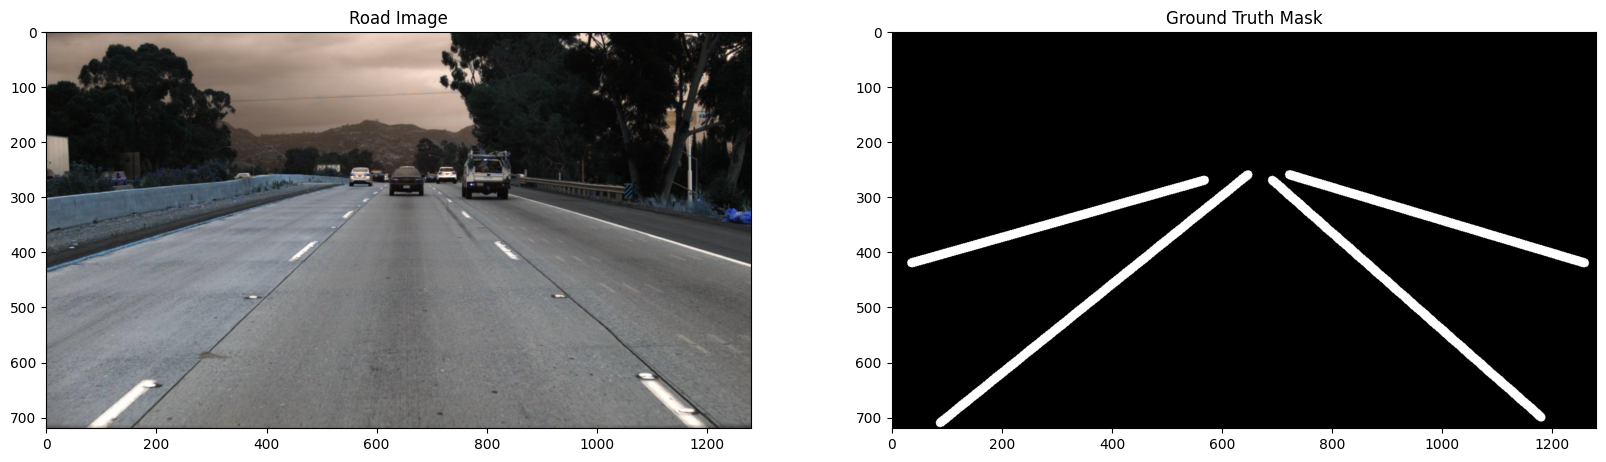

In [5]:
img_color = cv2.imread('/kaggle/working/tusimple_preprocessed/training/frames/0601_1494453497604532231.jpg')
img_mask = cv2.imread('/kaggle/working/tusimple_preprocessed/training/lane-masks/0601_1494453497604532231.jpg')

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_color/255.)
plt.title('Road Image')

plt.subplot(1, 2, 2)
plt.imshow(img_mask/255., cmap='gray')
plt.title('Ground Truth Mask')

plt.show()

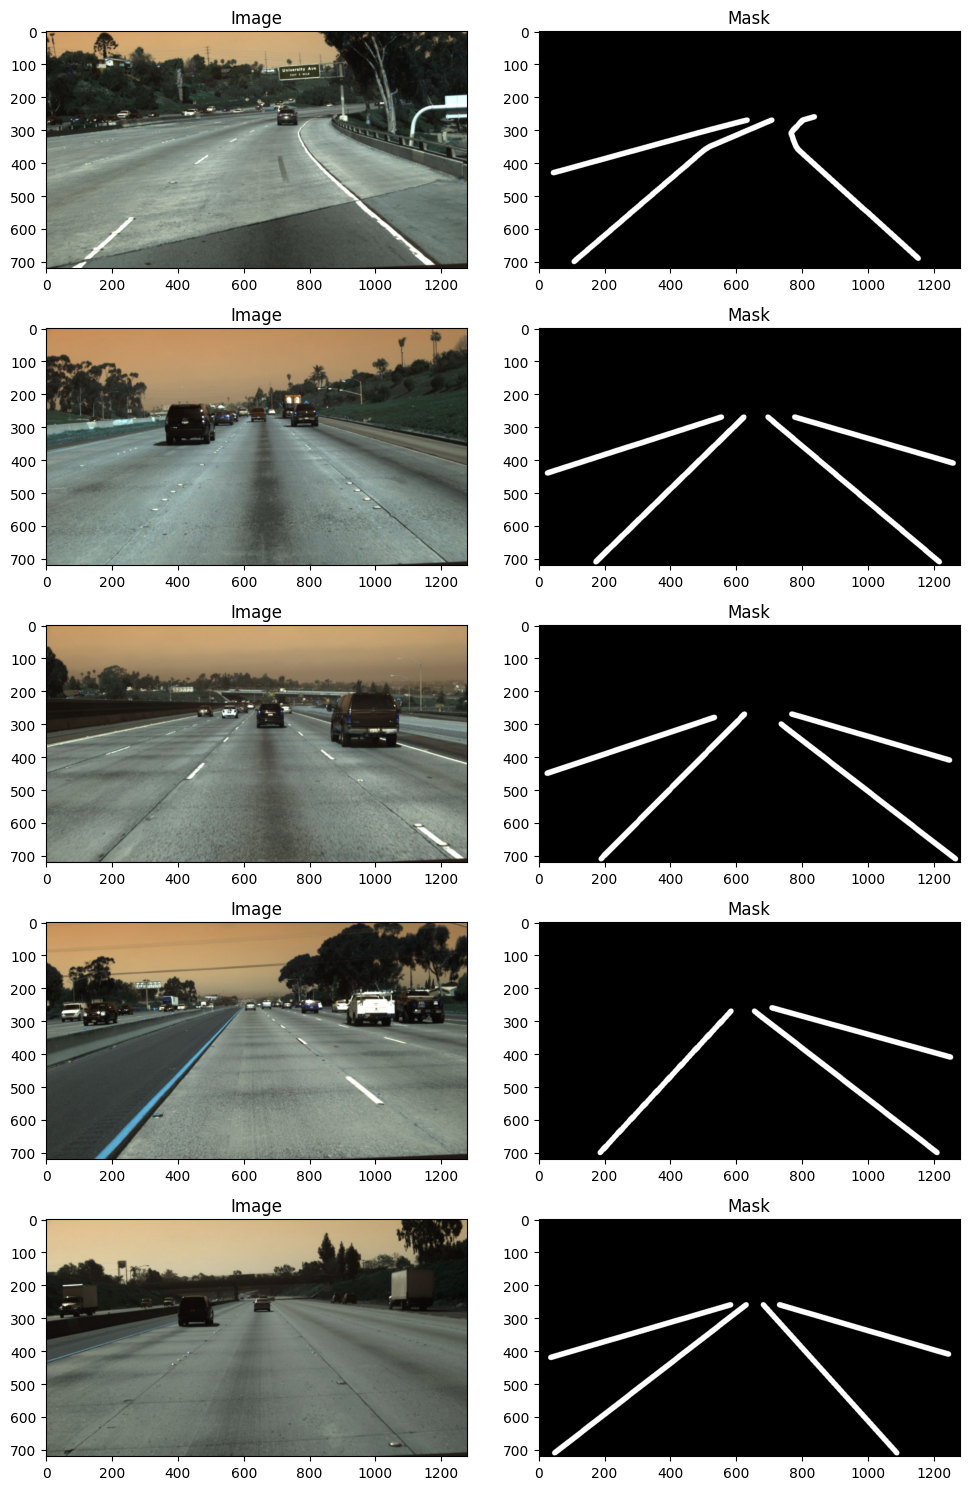

In [6]:
import random

# Visualize a few image-mask pairs
def visualize_samples(num_samples=5):
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    
    images_path = '/kaggle/working/tusimple_preprocessed/training/frames'
    masks_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks'
    
    image_files = os.listdir(images_path)
    random_samples = random.sample(image_files, num_samples)
    
    for i, img_file in enumerate(random_samples):
        img = cv2.imread(os.path.join(images_path, img_file))
        mask = cv2.imread(os.path.join(masks_path, img_file), cv2.IMREAD_GRAYSCALE)
        ax[i, 0].imshow(img / 255.0)
        ax[i, 0].set_title('Image')
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 1].set_title('Mask')
    
    plt.tight_layout()
    plt.show()

# Visualize 5 samples
visualize_samples(5)


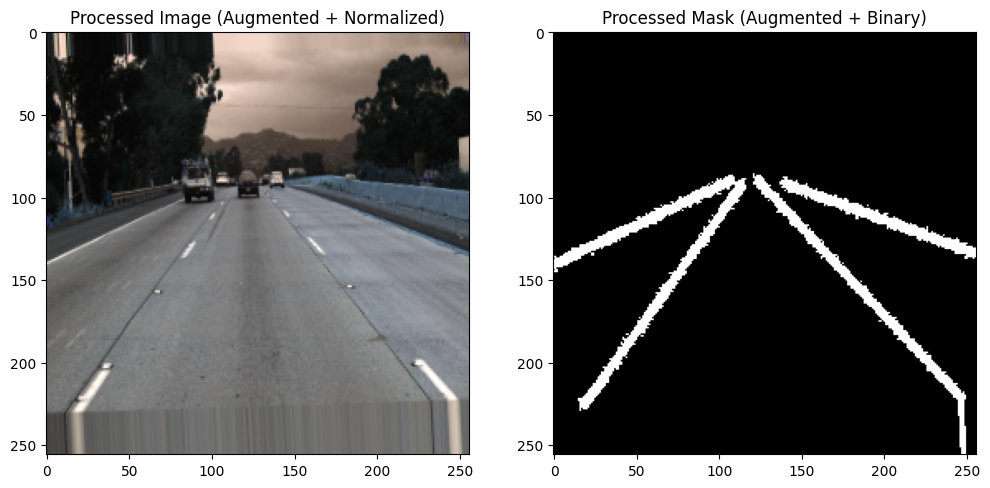

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

IMG_HEIGHT = 256
IMG_WIDTH = 256

def resize_image_and_mask(image, mask):
    # Resize image and mask to fixed dimensions
    image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    return image_resized, mask_resized

def normalize_image(image):
    # Normalize pixel values to [0, 1]
    normalized_image = image / 255.0
    return normalized_image

data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.01,
                     zoom_range=[0.9, 1.25],
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def augment_image_and_mask(image, mask):
    seed = np.random.randint(0, 1000)
    
    image_augmented = image_datagen.random_transform(image, seed=seed)
    mask = np.stack([mask, mask, mask], axis=-1)
    mask_augmented = mask_datagen.random_transform(mask, seed=seed)
    mask_augmented = mask_augmented[:, :, 0]
    return image_augmented, mask_augmented

def process_data(image_path, mask_path):
    # 1. Read the image and mask
    image = cv2.imread(image_path)  # BGR format by default
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask

    # 2. Resize both image and mask to 256x256 (to ensure consistent input size)
    image_resized = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    # 3. Augment the image and mask if needed
    image_augmented, mask_augmented = augment_image_and_mask(image_resized, mask_resized)

    # 4. Normalize the image to [0, 1]
    image_normalized = image_augmented.astype(np.float32) / 255.0

    # 5. Convert mask to binary and ensure float32 type
    mask_binary = (mask_augmented > 0).astype(np.float32)  # Binary mask (0 or 1)
    mask_binary = np.expand_dims(mask_binary, axis=-1)  # Add channel dimension

    return image_normalized, mask_binary

sample_image_path = '/kaggle/working/tusimple_preprocessed/training/frames/0601_1494453497604532231.jpg'
sample_mask_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks/0601_1494453497604532231.jpg'

image_processed, mask_processed = process_data(sample_image_path, sample_mask_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_processed)
plt.title('Processed Image (Augmented + Normalized)')

plt.subplot(1, 2, 2)
plt.imshow(mask_processed, cmap='gray')
plt.title('Processed Mask (Augmented + Binary)')

plt.show()

In [8]:
sample_image = cv2.imread(sample_image_path)
sample_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

print(f"Sample Image shape: {sample_image.shape}")
print(f"Sample Mask shape: {sample_mask.shape}")

Sample Image shape: (720, 1280, 3)
Sample Mask shape: (720, 1280)


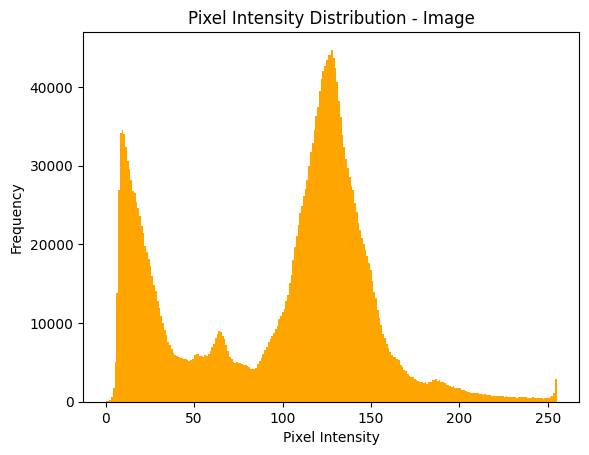

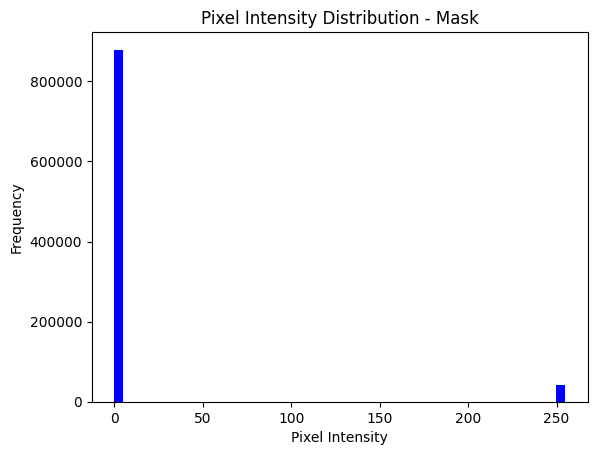

In [9]:
plt.hist(sample_image.ravel(), bins=256, color='orange', )
plt.title('Pixel Intensity Distribution - Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

plt.hist(sample_mask.ravel(), bins=50, color='blue', )
plt.title('Pixel Intensity Distribution - Mask')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [10]:
pip install tensorflow keras tensorflow-addons segmentation-models


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"  # Force segmentation-models to use TensorFlow's Keras

In [12]:
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

def build_unetpp():
    model = Unet('resnet34', input_shape=(256, 256, 3), classes=1, activation='sigmoid',
                 encoder_weights='imagenet', decoder_use_batchnorm=True)
    model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])
    return model


Segmentation Models: using `tf.keras` framework.


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Prepare paths for the dataset
train_images_path = '/kaggle/working/tusimple_preprocessed/training/frames'
train_masks_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks'

# Example: Prepare the data (X_train, Y_train) from your dataset
X_train = []  # List of preprocessed training images
Y_train = []  # List of corresponding masks

# Assuming process_data is used to load and process images
for image_file in os.listdir(train_images_path):
    image_path = os.path.join(train_images_path, image_file)
    mask_path = os.path.join(train_masks_path, image_file)

    image, mask = process_data(image_path, mask_path)
    
    X_train.append(image)
    Y_train.append(mask)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Training masks shape: {Y_train.shape}")

Training data shape: (3626, 256, 256, 3)
Training masks shape: (3626, 256, 256, 1)


In [16]:
batch_size = 8
epochs = 10
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

unetpp = build_unetpp()
attention_unet = build_attention_unet()
deeplabv3 = build_deeplabv3()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
unetpp.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [18]:
print("Training UNet++...")
UNetpp=unetpp.fit(X_train, Y_train, 
           epochs=epochs, batch_size=batch_size, validation_split=0.1, 
           callbacks=[checkpoint])

Training UNet++...
Epoch 1/10


I0000 00:00:1729671848.067734      84 service.cc:145] XLA service 0x7b456c0022a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729671848.067803      84 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729671848.067809      84 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-23 08:24:22.778482: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[8,3,262,262]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,128,128]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}), window={size=7x7 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-23 08:24:22.945617: E external/local_xla/xl

408/408 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - iou_score: 0.3214 - loss: 0.8960 - val_iou_score: 0.0254 - val_loss: 1.3307
Epoch 2/10
  1/408 ━━━━━━━━━━━━━━━━━━━━ 1:11 176ms/step - iou_score: 0.5964 - loss: 0.4969

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - iou_score: 0.5889 - loss: 0.4960 - val_iou_score: 0.3269 - val_loss: 0.8541
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6127 - loss: 0.4667 - val_iou_score: 0.6117 - val_loss: 0.4661
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6305 - loss: 0.4453 - val_iou_score: 0.5865 - val_loss: 0.5155
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6370 - loss: 0.4374 - val_iou_score: 0.6245 - val_loss: 0.4539
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6527 - loss: 0.4178 - val_iou_score: 0.6210 - val_loss: 0.4617
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6617 - loss: 0.4074 - val_iou_score: 0.6153 - val_loss: 0.4702
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6686 - loss: 0.3992 - val_iou_score: 0.6286 - val_loss: 0.4565
Epoch 9/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - iou_score: 0.6818 - los

Copied 0313-2_22500.jpg to test directories
Copied 0313-2_1290.jpg to test directories
Copied 0313-1_7340.jpg to test directories
Copied 0313-2_1860.jpg to test directories
Copied 0313-1_16820.jpg to test directories
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


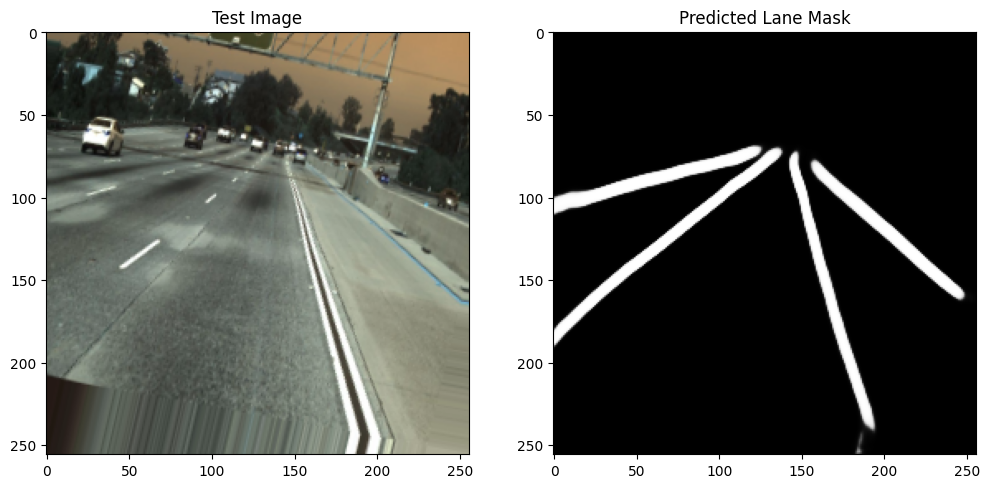

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


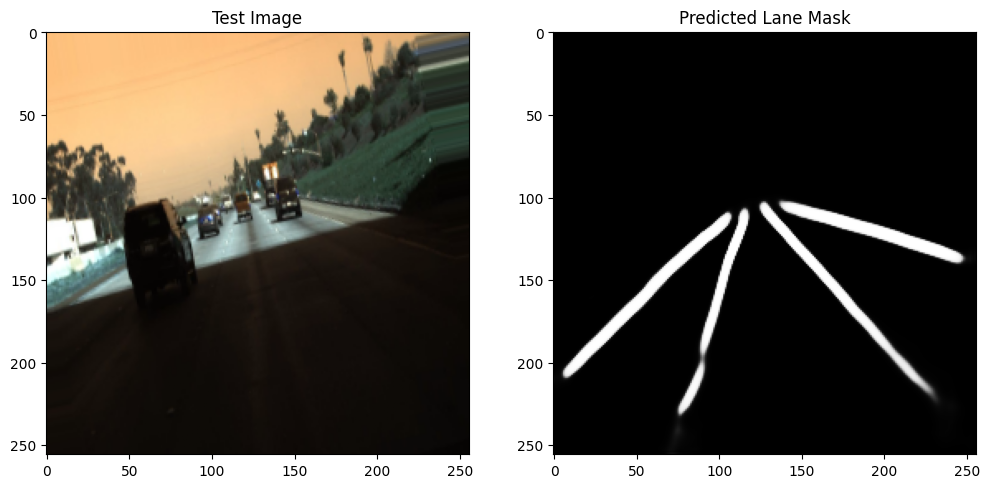

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


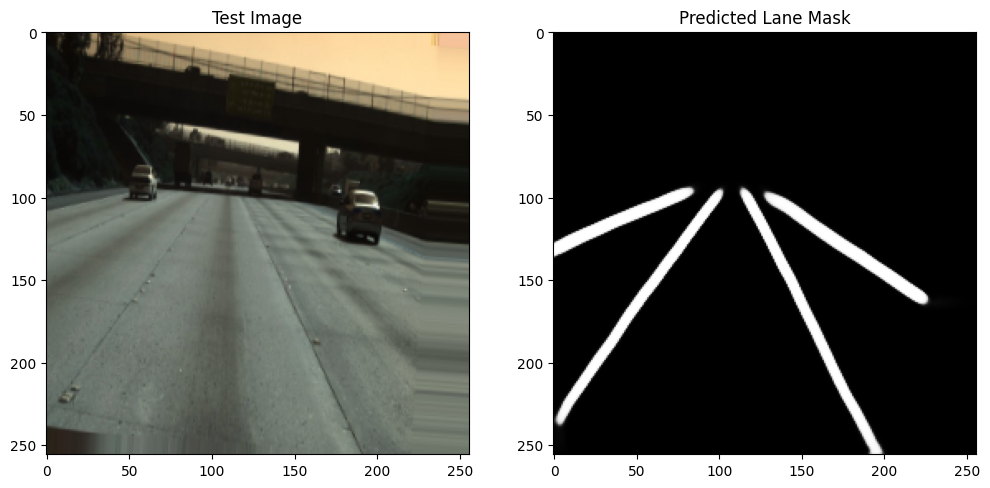

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


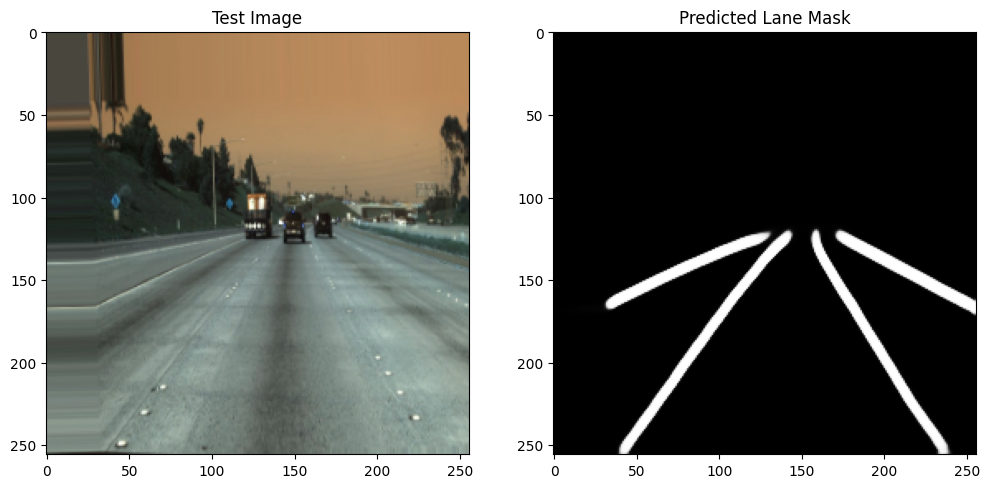

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


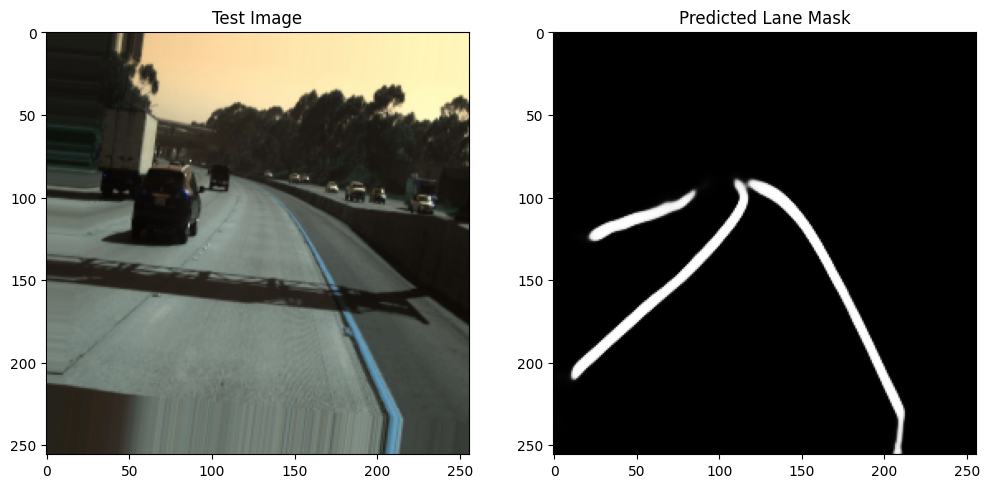

In [19]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Create the test directory structure if it doesn't exist
test_frames_dir = '/kaggle/working/tusimple_preprocessed/test/frames'
test_masks_dir = '/kaggle/working/tusimple_preprocessed/test/lane-masks'

os.makedirs(test_frames_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

# Copy images and masks from the training set to the test set
training_frames = '/kaggle/working/tusimple_preprocessed/training/frames'
training_masks = '/kaggle/working/tusimple_preprocessed/training/lane-masks'

# Copy a set number of images and masks for testing (e.g., first 5)
num_images_to_copy = 5
training_images = os.listdir(training_frames)[:num_images_to_copy]

for test_image_file in training_images:
    # Copy each image and its corresponding mask
    shutil.copy(os.path.join(training_frames, test_image_file), test_frames_dir)
    shutil.copy(os.path.join(training_masks, test_image_file), test_masks_dir)
    print(f"Copied {test_image_file} to test directories")

# Load and process the copied test images and masks
for test_image_file in training_images:
    test_image_path = os.path.join(test_frames_dir, test_image_file)
    test_mask_path = os.path.join(test_masks_dir, test_image_file)

    # Check for existence of image and mask files
    if not os.path.exists(test_image_path):
        print(f"Image file not found at: {test_image_path}")
        continue
    if not os.path.exists(test_mask_path):
        print(f"Mask file not found at: {test_mask_path}")
        continue

    # Process the image and mask
    test_image, test_mask = process_data(test_image_path, test_mask_path)

    # Make a prediction
    predicted_mask = unetpp.predict(np.expand_dims(test_image, axis=0))
    # Display the prediction
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Test Image')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.title('Predicted Lane Mask')

    plt.show()

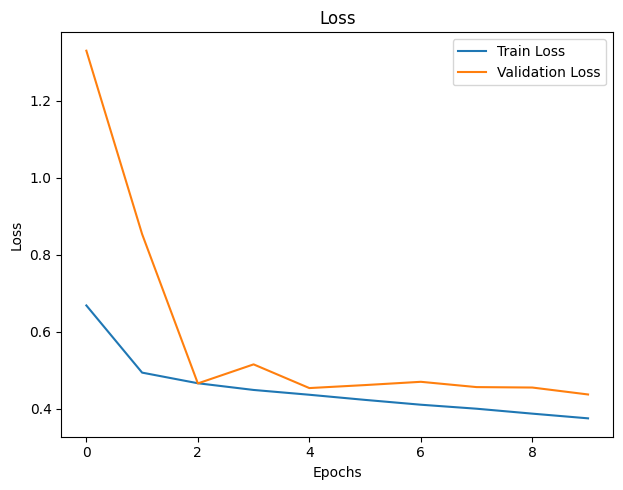

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot IoU
    if 'iou' in history.history and 'val_iou' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['iou'], label='Train IoU')
        plt.plot(history.history['val_iou'], label='Validation IoU')
        plt.title('IoU')
        plt.xlabel('Epochs')
        plt.ylabel('IoU')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot U-Net training history
plot_training_history(UNetpp)


In [21]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    # Flatten both arrays to ensure shape consistency
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=1)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=1)
    iou = jaccard_score(y_true_flat, y_pred_flat)

    # Dice coefficient
    dice_coefficient = 2 * np.sum(y_true_flat * y_pred_flat) / (
        np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-6
    )

    return accuracy, precision, recall, f1, iou, dice_coefficient
from tensorflow.image import resize
#Resize and preprocess images and masks
def load_and_preprocess_image(image_path, target_size):
    image = plt.imread(image_path) / 255.0  # Normalize to [0, 1]
    image = resize(image, target_size).numpy()  # Resize to target size
    return image


# Load test data from the TuSimple dataset
test_frames_dir = '/kaggle/working/tusimple_preprocessed/test/frames'
test_masks_dir = '/kaggle/working/tusimple_preprocessed/test/lane-masks'

X_test, Y_test = [], []
target_size = (256, 256)  # Adjust size to be divisible by 32

# Load and preprocess test data
for test_file in os.listdir(test_frames_dir):
    test_image_path = os.path.join(test_frames_dir, test_file)
    test_mask_path = os.path.join(test_masks_dir, test_file)

    if not os.path.exists(test_image_path) or not os.path.exists(test_mask_path):
        print(f"Missing image or mask: {test_file}")
        continue

    # Load and resize images and masks
    test_image = load_and_preprocess_image(test_image_path, target_size)
    test_mask = load_and_preprocess_image(test_mask_path, target_size)

    # Ensure grayscale mask is binary
    test_mask = (test_mask > 0.5).astype(np.uint8)

    X_test.append(test_image)
    Y_test.append(test_mask)

# Convert to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Add channel dimension to masks if necessary
if len(Y_test.shape) == 3:
    Y_test = np.expand_dims(Y_test, axis=-1)

In [22]:
def evaluate_model(model, X_test, Y_test, model_name):
    # Run predictions
    predicted_masks = model.predict(X_test, batch_size=1)

    # Debugging: Print shapes to verify consistency
    print(f"Y_test shape: {Y_test.shape}")  # Ground truth masks
    print(f"Predicted masks shape: {predicted_masks.shape}")  # Model predictions

    # Binary conversion of predicted masks
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

    # Handle potential shape mismatches between predicted masks and Y_test
    if predicted_masks_binary.shape[-1] == 1 and Y_test.shape[-1] == 3:
        Y_test = np.mean(Y_test, axis=-1, keepdims=True)  # Convert RGB to grayscale

    # Ensure prediction shape matches ground truth shape
    predicted_masks_binary = np.squeeze(predicted_masks_binary, axis=-1)
    predicted_masks_binary = np.expand_dims(predicted_masks_binary, axis=-1)

    print(f"Adjusted predicted masks shape: {predicted_masks_binary.shape}")

    # Flatten masks for metric calculation
    Y_test_flat = Y_test.flatten()
    predicted_flat = predicted_masks_binary.flatten()

    # Calculate metrics
    accuracy, precision, recall, f1, iou, dice = calculate_metrics(Y_test_flat, predicted_flat)

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1 Score: {f1:.4f}, IoU: {iou:.4f}, "
          f"Dice Coefficient: {dice:.4f}")

    # Display a few predictions
    for i in range(min(5, len(X_test))):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(Y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')

        plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Y_test shape: (5, 256, 256, 3)
Predicted masks shape: (5, 256, 256, 1)
Adjusted predicted masks shape: (5, 256, 256, 1)
U-Net++ - Accuracy: 0.9718, Precision: 0.6059, Recall: 0.8873, F1 Score: 0.7201, IoU: 0.5627, Dice Coefficient: 0.7201


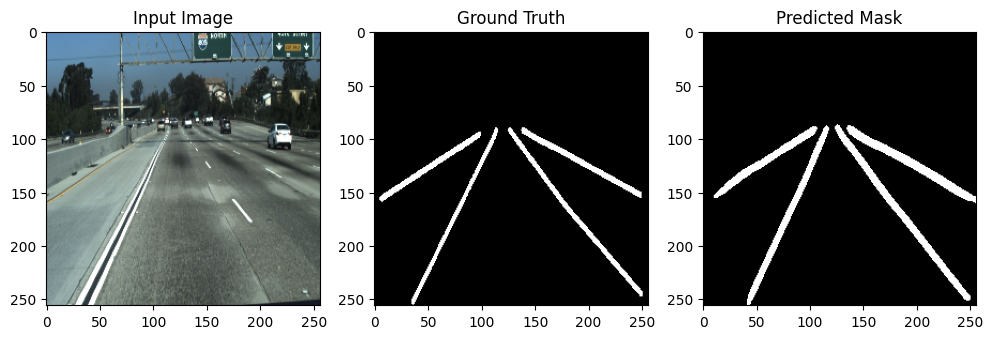

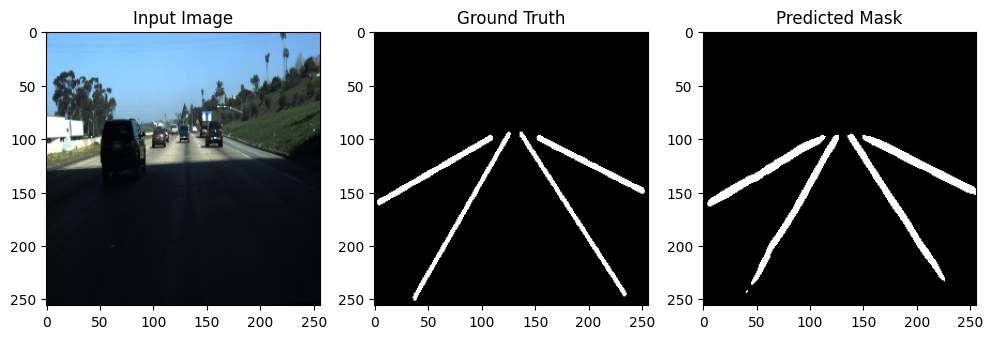

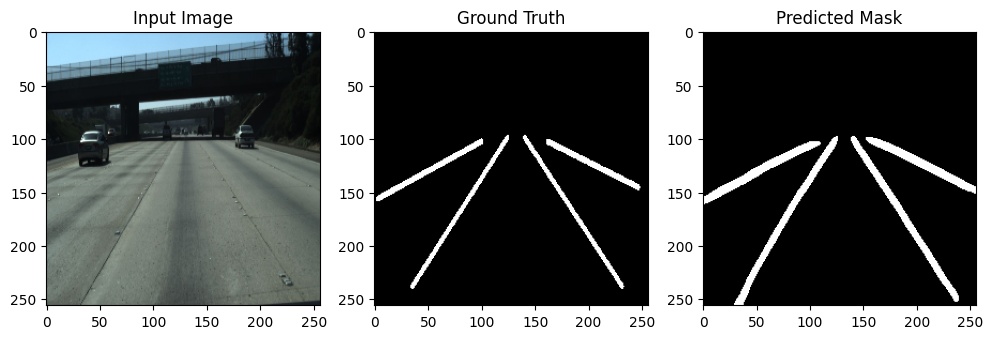

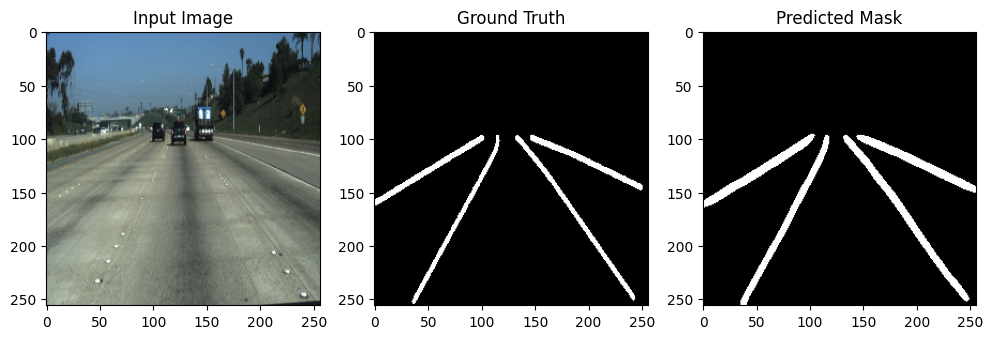

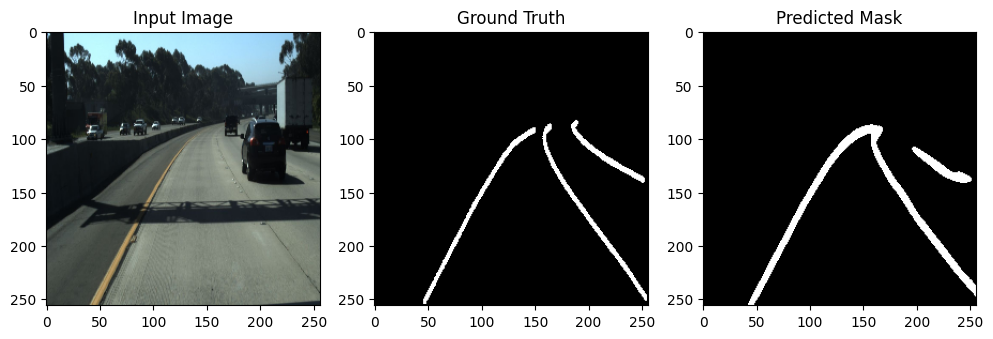

In [23]:
evaluate_model(unetpp, X_test, Y_test, "U-Net++")